### Import Libraries

In [1]:
import h5py
import hdf5plugin
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from pathlib import Path
import pickle
import pandas as pd

### Open the HDF file

In this step we assume that the FLOGA dataset has been downloaded into the folder `data/`.

In [ ]:
# floga_path = Path('data')
floga_path = Path('/mnt/FLOGA/dataset/FLOGA_dataset_2018_sen2_60_mod_500.h5')
hdf = h5py.File(floga_path, 'r')

The outline of the HDF file is shown below:

where `<year>` is the year of the examined data, `<event_id>` is a unique identifier of each event in a single year, and `<gsd>` is the spatial resolution of the Sentinel-2 imagery contained in this HDF file.

<font color='red'>attrs</font> include the following metadata:
 - `post_image_date`: The date of the post-image acquisition
 - `post_modis_file`: The identifier of the MODIS image
 - `post_sen2_file`: The identifier of the Sentinel-2 image
 - `pre_image_date`: The date of the pre-fire image acquisition
 - `pre_modis_file`: The identifier of the MODIS image
 - `pre_sen2_file`: The identifier of the Sentinel-2 image

In [4]:
hdf.keys()

<KeysViewHDF5 ['2018']>

In [6]:
hdf['2018'].keys()

<KeysViewHDF5 ['0', '10', '13', '14', '15', '17', '19', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '38', '39', '40', '5', '7']>

We can see that this particular HDF file contains data for the year 2017 (as can also be derived from the HDF filename), and in particular 44 fire events with IDs: 0, 10, 17, 19, etc.

Let's examine the first event.

In [6]:
hdf['2018']['0'].keys()

<KeysViewHDF5 ['clc_100_mask', 'label', 'mod_500_cloud_post', 'mod_500_cloud_pre', 'mod_500_post', 'mod_500_pre', 'sea_mask', 'sen2_60_cloud_post', 'sen2_60_cloud_pre', 'sen2_60_post', 'sen2_60_pre']>

This particular event with ID 0 contains all necessary data, i.e. CLC mask, sea mask, cloud masks, MODIS imagery, Sentinel-2 imagery and label.
We can also see that the spatial resolution of the Sentinel-2 data is 60m (as can also be derived from the HDF filename).

Let's open the pre-fire Sentinel-2 image.

In [3]:
img = hdf['2018']['0']['label']
np.any(img[:] == 2)
img.shape
# np.unique(img[:, 0:img.shape[1], 0:img.shape[2]])

(1, 1626, 2040)

In [7]:
img = hdf['2018']['0']['sen2_60_cloud_pre'][:]
np.where(img[0]==9)[0].shape

(301,)

In [34]:
img = hdf['2018']['0']['sea_mask'][:]
np.unique(img, return_counts=True)

(array([  0,   1,   2,   3,   4, 253, 255], dtype=uint8),
 array([1929766,    8090,     277,     426,   45639,   17976, 1314866]))

In [9]:
hdf['2018']['0']['sen2_60_pre'][:]

array([[[434, 436, 435, ...,   0,   0,   0],
        [462, 472, 455, ...,   0,   0,   0],
        [466, 463, 446, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[324, 326, 325, ...,   0,   0,   0],
        [344, 353, 341, ...,   0,   0,   0],
        [348, 349, 346, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[221, 221, 224, ...,   0,   0,   0],
        [237, 250, 233, ...,   0,   0,   0],
        [246, 240, 242, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       ...,

       [[115, 115, 115, ...,   0,   0,   0],
        [132, 141, 132, ...,   0,   0,   0],
        [145, 132, 136, ...,   0,   0,   0

We see that it is a numpy array of dtype `int32`.

Now let's take a look at the attributes.

In [18]:
hdf['2018']['0'].attrs.keys()

<KeysViewHDF5 ['post_image_date', 'post_modis_file', 'post_sen2_file', 'pre_image_date', 'pre_modis_file', 'pre_sen2_file']>

In [53]:
for k, v in hdf['2018']['0'].attrs.items():
    print(f'{k}: {v}')

post_image_date: 2018-09-01
post_modis_file: MOD09GA.A2018244.h19v05.006.2018246030653
post_sen2_file: S2A_MSIL2A_20180901T092031_N0208_R093_T34SEG_20180901T131611
pre_image_date: 2018-07-03
pre_modis_file: MOD09GA.A2018184.h19v05.006.2018186221221
pre_sen2_file: S2A_MSIL2A_20180703T092031_N0208_R093_T34SEG_20180703T121025


### Visualize images and labels

Let's visualize a sample from this HDF file.

In [7]:
# Define custom colormap for the labels
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', [(0, 0, 0, 10), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0), (0.8647058823529412, 0.30980392156862746, 0.45882352941176474, 1.0)], 3)
cmap_sea = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap clouds', [(0, 0, 0, 1.0), (1.0, 1.0, 1.0, 1.0)], 2)
cmap_clc = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap clc', 
    [
        (0, 0, 0, 1.0),  # NODATA
        (0.902, 0.0, 0.302, 1.0),  # Continuous urban fabric
        (1.0, 0.0, 0.0, 1.0),  # Discontinuous urban fabric
        (0.8, 0.302, 0.949, 1.0),  # Industrial or commercial units
        (0.8, 0.0, 0.0, 1.0),  # Road and rail networks and associated land
        (0.902, 0.8, 0.8, 1.0),  # Port areas
        (0.901, 0.8, 0.902, 1.0),  # Airports
        (0.651, 0.0, 0.8, 1.0),  # Mineral extraction sites
        (0.651, 0.302, 1.0, 1.0),  # Dump sites
        (1.0, 0.302, 1.0, 1.0),  # Construction sites
        (1.0, 0.651, 1.0, 1.0),  # Green urban areas
        (1.0, 0.902, 1.0, 1.0),  # Sport and leisure facilities
        (1.0, 1.0, 0.659, 1.0),  # Non-irrigated arable land
        (1.0, 1.0, 0.0, 1.0),  # Permanently irrigated land
        (0.902, 0.902, 0.0, 1.0),  # Rice fields
        (0.902, 0.502, 0.0, 1.0),  # Vineyards
        (0.949, 0.651, 0.302, 1.0),  # Fruit trees and berry plantations
        (0.902, 0.651, 0.0, 1.0),  # Olive groves
        (0.902, 0.902, 0.302, 1.0),  # Pastures
        (1.0, 0.902, 0.651, 1.0),  # Annual crops associated with permanent crops
        (1.0, 0.902, 0.302, 1.0),  # Complex cultivation patterns
        (0.902, 0.8, 0.302, 1.0),  # Land principally occupied by agriculture with significant areas of natural vegetation
        (0.949, 0.8, 0.651, 1.0),  # Agro-forestry areas
        (0.502, 1.0, 0.0, 1.0),  # Broad-leaved forest
        (0.0, 0.651, 0.0, 1.0),  # Coniferous forest
        (0.302, 1.0, 0.0, 1.0),  # Mixed forest
        (0.8, 0.949, 0.302, 1.0),  # Natural grasslands
        (0.651, 1.0, 0.502, 1.0),  # Moors and heathland
        (0.651, 0.902, 0.302, 1.0),  # Sclerophyllous vegetation
        (0.651, 0.949, 0.0, 1.0),  # Transitional woodland-shrub
        (0.902, 0.902, 0.902, 1.0),  # Beaches dunes sands
        (0.8, 0.8, 0.8, 1.0),  # Bare rocks
        (0.8, 1.0, 0.8, 1.0),  # Sparsely vegetated areas
        (0.0, 0.0, 0.0, 1.0),  # Burnt areas
        (0.651, 0.902, 0.8, 1.0),  # Glaciers and perpetual snow
        (0.651, 0.651, 1.0, 1.0),  # Inland marshes
        (0.302, 0.302, 1.0, 1.0),  # Peat bogs
        (0.8, 0.8, 1.0, 1.0),  # Salt marshes
        (0.902, 0.902, 1.0, 1.0),  # Salines
        (0.651, 0.651, 0.902, 1.0),  # Intertidal flats
        (0.0, 0.8, 0.949, 1.0),  # Water courses
        (0.0, 1.0, 0.651, 1.0),  # Coastal lagoons
        (0.651, 1.0, 0.902, 1.0),  # Estuaries
        (0.902, 0.949, 1.0, 1.0),  # Sea and ocean
    ],
    44
)

In [10]:
for i in hdf['2018'].keys():
    print(i)

0
10
13
14
15
17
19
22
23
24
25
26
27
28
29
30
31
32
33
34
35
38
39
40
5
7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.01057306..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.022276677..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..7.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..7.0].


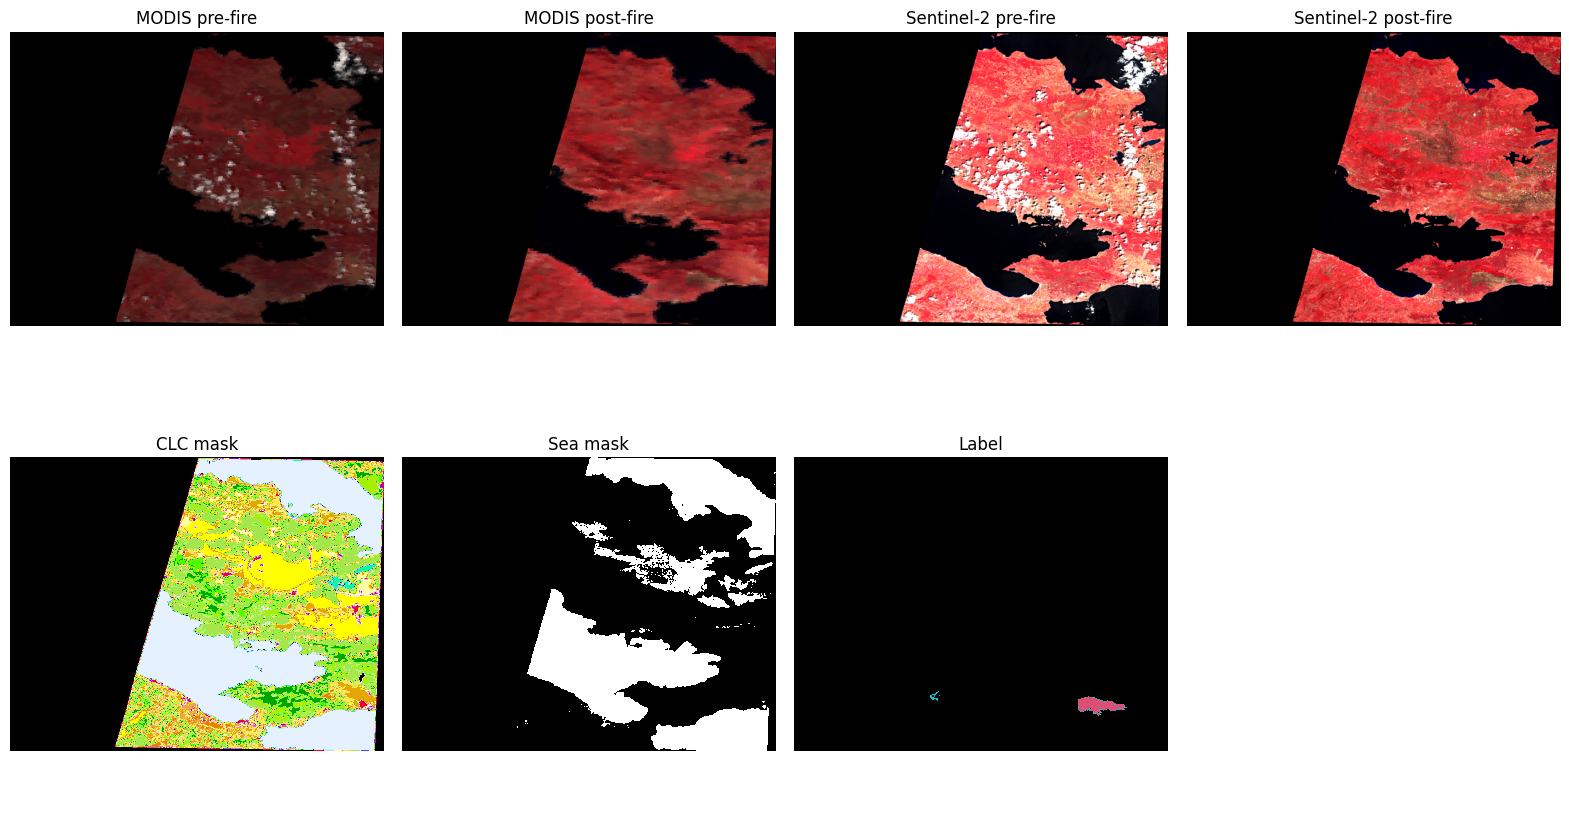

In [11]:
def scale_image(img):
    img = img.astype(np.float32)
    return img / img.max()

event_id = '14'
bands = 'rgb'  # 'nrg' for NIR-R-G composites, 'rgb' for R-G-B composites

if bands == 'nrg':
    # Get band indices for R, G, B
    sen2_plot_bands = [3, 2, 1]
    mod_plot_bands = [0, 3, 2]
else:
    # Get band indices for NIR, R, G
    sen2_plot_bands = [10, 3, 2]
    mod_plot_bands = [1, 0, 3]

fig, ax = plt.subplots(2, 4, figsize=(20, 11))

# MODIS pre-fire image
img = hdf['2018'][event_id]['mod_500_pre'][:][mod_plot_bands, ...]
img = scale_image(img)
img = np.moveaxis(img, 0, -1)
ax[0, 0].imshow(img)
ax[0, 0].set_title('MODIS pre-fire')

# MODIS post-fire image
img = hdf['2018'][event_id]['mod_500_post'][:][mod_plot_bands, ...]
img = scale_image(img)
img = np.moveaxis(img, 0, -1)
ax[0, 1].imshow(img)
ax[0, 1].set_title('MODIS post-fire')

# Sentinel-2 pre-fire image
img = hdf['2018'][event_id]['sen2_60_pre'][:][sen2_plot_bands, ...]
img = scale_image(img)
img = np.moveaxis(img, 0, -1)
ax[0, 2].imshow(img * 7)
ax[0, 2].set_title('Sentinel-2 pre-fire')

# Sentinel-2 post-fire image
img = hdf['2018'][event_id]['sen2_60_post'][:][sen2_plot_bands, ...]
img = scale_image(img)
img = np.moveaxis(img, 0, -1)
ax[0, 3].imshow(img * 7)
ax[0, 3].set_title('Sentinel-2 post-fire')

# CLC mask
img = hdf['2018'][event_id]['clc_100_mask'][:]
img[(img == 48) | (img == 128)] = 0  # NODATA
img = np.moveaxis(img, 0, -1)
ax[1, 0].imshow(img, vmin=0, vmax=43, cmap=cmap_clc)
ax[1, 0].set_title('CLC mask')

# Sea mask
img = hdf['2018'][event_id]['sea_mask'][:]
ax[1, 1].imshow(img.squeeze(), vmin=0, vmax=1, cmap=cmap_sea)
ax[1, 1].set_title('Sea mask')

# Label
img = hdf['2018'][event_id]['label'][:]
ax[1, 2].imshow(img.squeeze(), vmin=0, vmax=2, cmap=cmap)
ax[1, 2].set_title('Label')

# Remove axes and ticks
for i in range(2):
    for j in range(4):
        # Remove all axis labels
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

        ax[i, j].spines['top'].set_visible(False)
        ax[i, j].spines['right'].set_visible(False)
        ax[i, j].spines['bottom'].set_visible(False)
        ax[i, j].spines['left'].set_visible(False)

plt.subplots_adjust(wspace=0.05, hspace=0.01)


### Explore .npy files

In [ ]:
fp = '/mnt/FLOGA/data/dataset/2017/sample00000000_43_2017.sen2_60_pre.npy'

In [18]:
data = np.load(fp)

In [19]:
data.shape

(11, 256, 256)

### Explore pickle files

In [ ]:
patches = pickle.load(open('/mnt/FLOGA/data/sen2_60_mod_500/allEvents_60-20-20_r1_test.pkl', 'rb'))

In [4]:
patches

{'sample00000021_69_2017': {'S2_after_cloud': PosixPath('../data/dataset/2017/sample00000021_69_2017.sen2_60_cloud_post.npy'),
  'S2_after_image': PosixPath('../data/dataset/2017/sample00000021_69_2017.sen2_60_post.npy'),
  'MOD_after_image': PosixPath('../data/dataset/2017/sample00000021_69_2017.mod_500_post.npy'),
  'sea_mask': PosixPath('../data/dataset/2017/sample00000021_69_2017.sea_mask.npy'),
  'positive_flag': False,
  'MOD_after_cloud': PosixPath('../data/dataset/2017/sample00000021_69_2017.mod_500_cloud_post.npy'),
  'label': PosixPath('../data/dataset/2017/sample00000021_69_2017.label.npy'),
  'clc_mask': PosixPath('../data/dataset/2017/sample00000021_69_2017.clc_100_mask.npy'),
  'S2_before_cloud': PosixPath('../data/dataset/2017/sample00000021_69_2017.sen2_60_cloud_pre.npy'),
  'MOD_before_cloud': PosixPath('../data/dataset/2017/sample00000021_69_2017.mod_500_cloud_pre.npy'),
  'S2_before_image': PosixPath('../data/dataset/2017/sample00000021_69_2017.sen2_60_pre.npy'),
  '

In [4]:
type(patches)

dict

In [6]:
del patches["sample00000026_0_2018"]

In [ ]:
pickle.dump(patches, open('/mnt/FLOGA/data/sen2_60_mod_500/allEvents_60-20-20_r1_v2_test.pkl', 'wb'))

In [7]:
len(patches.keys())

193

In [5]:
events_df = pd.DataFrame([{**{'sample_key': k}, **patches[k]} for k in sorted(list(patches.keys()))])

In [6]:
events_df

,sample_key,positive_flag,S2_after_image,clc_mask,sea_mask,S2_before_image,MOD_after_cloud,S2_before_cloud,MOD_before_image,label,S2_after_cloud,MOD_after_image,MOD_before_cloud
0,sample00000000_59_2021,True,../data/dataset/2021/sample00000000_59_2021.se...,../data/dataset/2021/sample00000000_59_2021.cl...,../data/dataset/2021/sample00000000_59_2021.se...,../data/dataset/2021/sample00000000_59_2021.se...,../data/dataset/2021/sample00000000_59_2021.mo...,../data/dataset/2021/sample00000000_59_2021.se...,../data/dataset/2021/sample00000000_59_2021.mo...,../data/dataset/2021/sample00000000_59_2021.la...,../data/dataset/2021/sample00000000_59_2021.se...,../data/dataset/2021/sample00000000_59_2021.mo...,../data/dataset/2021/sample00000000_59_2021.mo...
1,sample00000001_59_2021,True,../data/dataset/2021/sample00000001_59_2021.se...,../data/dataset/2021/sample00000001_59_2021.cl...,../data/dataset/2021/sample00000001_59_2021.se...,../data/dataset/2021/sample00000001_59_2021.se...,../data/dataset/2021/sample00000001_59_2021.mo...,../data/dataset/2021/sample00000001_59_2021.se...,../data/dataset/2021/sample00000001_59_2021.mo...,../data/dataset/2021/sample00000001_59_2021.la...,../data/dataset/2021/sample00000001_59_2021.se...,../data/dataset/2021/sample00000001_59_2021.mo...,../data/dataset/2021/sample00000001_59_2021.mo...
2,sample00000001_60_2020,False,../data/dataset/2020/sample00000001_60_2020.se...,../data/dataset/2020/sample00000001_60_2020.cl...,../data/dataset/2020/sample00000001_60_2020.se...,../data/dataset/2020/sample00000001_60_2020.se...,../data/dataset/2020/sample00000001_60_2020.mo...,../data/dataset/2020/sample00000001_60_2020.se...,../data/dataset/2020/sample00000001_60_2020.mo...,../data/dataset/2020/sample00000001_60_2020.la...,../data/dataset/2020/sample00000001_60_2020.se...,../data/dataset/2020/sample00000001_60_2020.mo...,../data/dataset/2020/sample00000001_60_2020.mo...
3,sample00000001_69_2017,False,../data/dataset/2017/sample00000001_69_2017.se...,../data/dataset/2017/sample00000001_69_2017.cl...,../data/dataset/2017/sample00000001_69_2017.se...,../data/dataset/2017/sample00000001_69_2017.se...,../data/dataset/2017/sample00000001_69_2017.mo...,../data/dataset/2017/sample00000001_69_2017.se...,../data/dataset/2017/sample00000001_69_2017.mo...,../data/dataset/2017/sample00000001_69_2017.la...,../data/dataset/2017/sample00000001_69_2017.se...,../data/dataset/2017/sample00000001_69_2017.mo...,../data/dataset/2017/sample00000001_69_2017.mo...
4,sample00000001_86_2017,False,../data/dataset/2017/sample00000001_86_2017.se...,../data/dataset/2017/sample00000001_86_2017.cl...,../data/dataset/2017/sample00000001_86_2017.se...,../data/dataset/2017/sample00000001_86_2017.se...,../data/dataset/2017/sample00000001_86_2017.mo...,../data/dataset/2017/sample00000001_86_2017.se...,../data/dataset/2017/sample00000001_86_2017.mo...,../data/dataset/2017/sample00000001_86_2017.la...,../data/dataset/2017/sample00000001_86_2017.se...,../data/dataset/2017/sample00000001_86_2017.mo...,../data/dataset/2017/sample00000001_86_2017.mo...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,sample00000061_101_2021,False,../data/dataset/2021/sample00000061_101_2021.s...,../data/dataset/2021/sample00000061_101_2021.c...,../data/dataset/2021/sample00000061_101_2021.s...,../data/dataset/2021/sample00000061_101_2021.s...,../data/dataset/2021/sample00000061_101_2021.m...,../data/dataset/2021/sample00000061_101_2021.s...,../data/dataset/2021/sample00000061_101_2021.m...,../data/dataset/2021/sample00000061_101_2021.l...,../data/dataset/2021/sample00000061_101_2021.s...,../data/dataset/2021/sample00000061_101_2021.m...,../data/dataset/2021/sample00000061_101_2021.m...
190,sample00000061_62_2021,True,../data/dataset/2021/sample00000061_62_2021.se...,../data/dataset/2021/sample00000061_62_2021.cl...,../data/dataset/2021/sample00000061_62_2021.se...,../data/dataset/2021/sample00000061_62_2021.se...,../data/dataset/2021/sample00000061_62_2021.mo.

In [7]:
events_df.dropna(axis=0, inplace=True)

In [8]:
events_df

,sample_key,positive_flag,S2_after_image,clc_mask,sea_mask,S2_before_image,MOD_after_cloud,S2_before_cloud,MOD_before_image,label,S2_after_cloud,MOD_after_image,MOD_before_cloud
0,sample00000000_59_2021,True,../data/dataset/2021/sample00000000_59_2021.se...,../data/dataset/2021/sample00000000_59_2021.cl...,../data/dataset/2021/sample00000000_59_2021.se...,../data/dataset/2021/sample00000000_59_2021.se...,../data/dataset/2021/sample00000000_59_2021.mo...,../data/dataset/2021/sample00000000_59_2021.se...,../data/dataset/2021/sample00000000_59_2021.mo...,../data/dataset/2021/sample00000000_59_2021.la...,../data/dataset/2021/sample00000000_59_2021.se...,../data/dataset/2021/sample00000000_59_2021.mo...,../data/dataset/2021/sample00000000_59_2021.mo...
1,sample00000001_59_2021,True,../data/dataset/2021/sample00000001_59_2021.se...,../data/dataset/2021/sample00000001_59_2021.cl...,../data/dataset/2021/sample00000001_59_2021.se...,../data/dataset/2021/sample00000001_59_2021.se...,../data/dataset/2021/sample00000001_59_2021.mo...,../data/dataset/2021/sample00000001_59_2021.se...,../data/dataset/2021/sample00000001_59_2021.mo...,../data/dataset/2021/sample00000001_59_2021.la...,../data/dataset/2021/sample00000001_59_2021.se...,../data/dataset/2021/sample00000001_59_2021.mo...,../data/dataset/2021/sample00000001_59_2021.mo...
2,sample00000001_60_2020,False,../data/dataset/2020/sample00000001_60_2020.se...,../data/dataset/2020/sample00000001_60_2020.cl...,../data/dataset/2020/sample00000001_60_2020.se...,../data/dataset/2020/sample00000001_60_2020.se...,../data/dataset/2020/sample00000001_60_2020.mo...,../data/dataset/2020/sample00000001_60_2020.se...,../data/dataset/2020/sample00000001_60_2020.mo...,../data/dataset/2020/sample00000001_60_2020.la...,../data/dataset/2020/sample00000001_60_2020.se...,../data/dataset/2020/sample00000001_60_2020.mo...,../data/dataset/2020/sample00000001_60_2020.mo...
3,sample00000001_69_2017,False,../data/dataset/2017/sample00000001_69_2017.se...,../data/dataset/2017/sample00000001_69_2017.cl...,../data/dataset/2017/sample00000001_69_2017.se...,../data/dataset/2017/sample00000001_69_2017.se...,../data/dataset/2017/sample00000001_69_2017.mo...,../data/dataset/2017/sample00000001_69_2017.se...,../data/dataset/2017/sample00000001_69_2017.mo...,../data/dataset/2017/sample00000001_69_2017.la...,../data/dataset/2017/sample00000001_69_2017.se...,../data/dataset/2017/sample00000001_69_2017.mo...,../data/dataset/2017/sample00000001_69_2017.mo...
4,sample00000001_86_2017,False,../data/dataset/2017/sample00000001_86_2017.se...,../data/dataset/2017/sample00000001_86_2017.cl...,../data/dataset/2017/sample00000001_86_2017.se...,../data/dataset/2017/sample00000001_86_2017.se...,../data/dataset/2017/sample00000001_86_2017.mo...,../data/dataset/2017/sample00000001_86_2017.se...,../data/dataset/2017/sample00000001_86_2017.mo...,../data/dataset/2017/sample00000001_86_2017.la...,../data/dataset/2017/sample00000001_86_2017.se...,../data/dataset/2017/sample00000001_86_2017.mo...,../data/dataset/2017/sample00000001_86_2017.mo...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,sample00000061_101_2021,False,../data/dataset/2021/sample00000061_101_2021.s...,../data/dataset/2021/sample00000061_101_2021.c...,../data/dataset/2021/sample00000061_101_2021.s...,../data/dataset/2021/sample00000061_101_2021.s...,../data/dataset/2021/sample00000061_101_2021.m...,../data/dataset/2021/sample00000061_101_2021.s...,../data/dataset/2021/sample00000061_101_2021.m...,../data/dataset/2021/sample00000061_101_2021.l...,../data/dataset/2021/sample00000061_101_2021.s...,../data/dataset/2021/sample00000061_101_2021.m...,../data/dataset/2021/sample00000061_101_2021.m...
190,sample00000061_62_2021,True,../data/dataset/2021/sample00000061_62_2021.se...,../data/dataset/2021/sample00000061_62_2021.cl...,../data/dataset/2021/sample00000061_62_2021.se...,../data/dataset/2021/sample00000061_62_2021.se...,../data/dataset/2021/sample00000061_62_2021.mo.

In [30]:
events_df.keys()

Index(['sample_key', 'positive_flag', 'S2_after_image', 'clc_mask', 'sea_mask',
       'S2_before_image', 'MOD_after_cloud', 'S2_before_cloud',
       'MOD_before_image', 'label', 'S2_after_cloud', 'MOD_after_image',
       'MOD_before_cloud'],
      dtype='object')

In [9]:
for i, x in enumerate(events_df["S2_after_image"]):
    if (type(x) == type(2.3)):
        print(i, x)

In [10]:
events_df.iloc[83]

sample_key                                     sample00000026_45_2017
positive_flag                                                   False
S2_after_image      ../data/dataset/2017/sample00000026_45_2017.se...
clc_mask            ../data/dataset/2017/sample00000026_45_2017.cl...
sea_mask            ../data/dataset/2017/sample00000026_45_2017.se...
S2_before_image     ../data/dataset/2017/sample00000026_45_2017.se...
MOD_after_cloud     ../data/dataset/2017/sample00000026_45_2017.mo...
S2_before_cloud     ../data/dataset/2017/sample00000026_45_2017.se...
MOD_before_image    ../data/dataset/2017/sample00000026_45_2017.mo...
label               ../data/dataset/2017/sample00000026_45_2017.la...
S2_after_cloud      ../data/dataset/2017/sample00000026_45_2017.se...
MOD_after_image     ../data/dataset/2017/sample00000026_45_2017.mo...
MOD_before_cloud    ../data/dataset/2017/sample00000026_45_2017.mo...
Name: 84, dtype: object

In [32]:
list(events_df[events_df['positive_flag']]['sample_key'].values)

['sample00000001_103_2021',
 'sample00000001_15_2018',
 'sample00000001_9_2021',
 'sample00000002_29_2017',
 'sample00000002_85_2017',
 'sample00000003_142_2021',
 'sample00000003_29_2017',
 'sample00000003_67_2017',
 'sample00000003_72_2019',
 'sample00000003_74_2020',
 'sample00000003_85_2017',
 'sample00000004_146_2021',
 'sample00000004_89_2020',
 'sample00000005_112_2021',
 'sample00000005_19_2020',
 'sample00000005_35_2017',
 'sample00000006_19_2020',
 'sample00000007_60_2021',
 'sample00000008_128_2021',
 'sample00000008_60_2021',
 'sample00000009_15_2019',
 'sample00000009_15_2021',
 'sample00000010_12_2019',
 'sample00000010_144_2021',
 'sample00000010_15_2019',
 'sample00000010_17_2020',
 'sample00000010_31_2020',
 'sample00000010_79_2019',
 'sample00000011_144_2021',
 'sample00000011_148_2021',
 'sample00000011_57_2019',
 'sample00000012_148_2021',
 'sample00000012_29_2019',
 'sample00000012_44_2020',
 'sample00000012_74_2020',
 'sample00000013_13_2020',
 'sample00000013_148

### Explore bands in sen2 and modis

In [35]:
sen2_selected_bands= {
    "B02": -1,
    "B03": -1,
    "B04": -1,
    "B05": -1,
    "B06": -1,
    "B07": -1,
    "B11": -1,
    "B12": -1,
    "B8A": -1
}

In [36]:
sen2 = {
    "B01": 0,
    "B02": 1,
    "B03": 2,
    "B04": 3,
    "B05": 4,
    "B06": 5,
    "B07": 6,
    "B09": 7,
    "B11": 8,
    "B12": 9,
    "B8A": 10
}

In [37]:
print(len(sen2), len(sen2_selected_bands))

11 9


In [39]:
for k in sen2.keys():
    if k not in sen2_selected_bands.keys():
        print(k)

B01
B09


In [18]:
x = events_df.iloc[0]

In [19]:
x.index

Index(['sample_key', 'clc_mask', 'S2_before_cloud', 'S2_after_cloud',
       'MOD_after_cloud', 'sea_mask', 'MOD_after_image', 'MOD_before_cloud',
       'S2_after_image', 'label', 'positive_flag', 'MOD_before_image',
       'S2_before_image'],
      dtype='object')

In [20]:
x["S2_before_image"]

PosixPath('../data/dataset/2021/sample00000000_1_2021.sen2_60_pre.npy')

In [21]:
x

sample_key                                      sample00000000_1_2021
clc_mask            ../data/dataset/2021/sample00000000_1_2021.clc...
S2_before_cloud     ../data/dataset/2021/sample00000000_1_2021.sen...
S2_after_cloud      ../data/dataset/2021/sample00000000_1_2021.sen...
MOD_after_cloud     ../data/dataset/2021/sample00000000_1_2021.mod...
sea_mask            ../data/dataset/2021/sample00000000_1_2021.sea...
MOD_after_image     ../data/dataset/2021/sample00000000_1_2021.mod...
MOD_before_cloud    ../data/dataset/2021/sample00000000_1_2021.mod...
S2_after_image      ../data/dataset/2021/sample00000000_1_2021.sen...
label               ../data/dataset/2021/sample00000000_1_2021.lab...
positive_flag                                                   False
MOD_before_image    ../data/dataset/2021/sample00000000_1_2021.mod...
S2_before_image     ../data/dataset/2021/sample00000000_1_2021.sen...
Name: 0, dtype: object

In [24]:
x["S2_before_image"].suffix

'.npy'

### Explore test results

In [ ]:
df = pd.read_json("/mnt/FLOGA/test-results.json")

In [3]:
df

,0,1,2,3,4,5,6,7,8,9
test Loss,6.650500,6.578400,6.323700,5.910800,7.152600,80.936300,6.337500,78.881200,60.455700,73.264800
VAL F1-score,0.320860,0.467760,0.614601,0.577456,0.474034,0.170759,0.134959,0.104739,0.076928,0.108491
test F-Score (Unburnt),99.034208,99.169618,99.329209,99.286705,99.168164,94.371319,98.895872,94.451219,97.031283,95.588249
test F-Score (Burnt),32.085955,46.775970,61.460066,57.745576,47.403431,17.075941,13.495940,10.473884,7.692835,10.849132
test IoU (Unburnt),98.086891,98.352921,98.667351,98.583511,98.350060,89.342514,97.815857,89.485847,94.233757,91.549316
test IoU (Burnt),19.108561,30.527830,44.362709,40.593166,31.064541,9.334990,7.236270,5.526353,4.000285,5.735703
test Precision (Unburnt),98.091406,98.356885,98.687547,98.595178,98.375809,98.589408,97.816551,98.082727,97.804666,98.021674
test Precision (Burnt),98.992205,99.446052,98.110366,98.792648,96.599782,10.473994,99.583179,6.556936,6.174681,7.224753
test Recall (Unburnt),99.995309,99.995899,99.979264,99.988002,99.973398,90.499353,99.999273,91.079021,96.270037,93.272722
test Recall (Burnt),19.145806,30.579832,44.745028,40.795550,31.407970,46.190903,7.238463,26.013964,10.200907,21.770599


In [5]:
df = df.transpose()
df

,test Loss,VAL F1-score,test F-Score (Unburnt),test F-Score (Burnt),test IoU (Unburnt),test IoU (Burnt),test Precision (Unburnt),test Precision (Burnt),test Recall (Unburnt),test Recall (Burnt),test Accuracy (Unburnt),test Accuracy (Burnt),test MeanIoU
0,6.6505,0.320860,99.034208,32.085955,98.086891,19.108561,98.091406,98.992205,99.995309,19.145806,98.095500,98.095500,58.597726
1,6.5784,0.467760,99.169618,46.775970,98.352921,30.527830,98.356885,99.446052,99.995899,30.579832,98.364753,98.364753,64.440376
2,6.3237,0.614601,99.329209,61.460066,98.667351,44.362709,98.687547,98.110366,99.979264,44.745028,98.681360,98.681360,71.515030
3,5.9108,0.577456,99.286705,57.745576,98.583511,40.593166,98.595178,98.792648,99.988002,40.795550,98.597091,98.597091,69.588339
4,7.1526,0.474034,99.168164,47.403431,98.350060,31.064541,98.375809,96.599782,99.973398,31.407970,98.362237,98.362237,64.707303
5,80.9363,0.170759,94.371319,17.075941,89.342514,9.334990,98.589408,10.473994,90.499353,46.190903,89.458185,89.458185,49.338749
6,6.3375,0.134959,98.895872,13.495940,97.815857,7.236270,97.816551,99.583179,99.999273,7.238463,97.819567,97.819567,52.526063
7,78.8812,0.104739,94.451219,10.473884,89.485847,5.526353,98.082727,6.556936,91.079021,26.013964,89.550114,89.550114,47.506100
8,60.4557,0.076928,97.031283,7.692835,94.233757,4.000285,97.804666,6.174681,96.270037,10.200907,94.247580,94.247580,49.117023
9,73.2648,0.108491,95.588249,10.849132,91.549316,5.735703,98.021674,7.224753,93.272722,21.770599,91.592556,91.592556,48.642510


In [14]:
df.sort_values("test Loss", inplace=True)

In [15]:
df

,test Loss,VAL F1-score,test F-Score (Unburnt),test F-Score (Burnt),test IoU (Unburnt),test IoU (Burnt),test Precision (Unburnt),test Precision (Burnt),test Recall (Unburnt),test Recall (Burnt),test Accuracy (Unburnt),test Accuracy (Burnt),test MeanIoU
3,5.9108,0.577456,99.286705,57.745576,98.583511,40.593166,98.595178,98.792648,99.988002,40.795550,98.597091,98.597091,69.588339
2,6.3237,0.614601,99.329209,61.460066,98.667351,44.362709,98.687547,98.110366,99.979264,44.745028,98.681360,98.681360,71.515030
6,6.3375,0.134959,98.895872,13.495940,97.815857,7.236270,97.816551,99.583179,99.999273,7.238463,97.819567,97.819567,52.526063
1,6.5784,0.467760,99.169618,46.775970,98.352921,30.527830,98.356885,99.446052,99.995899,30.579832,98.364753,98.364753,64.440376
0,6.6505,0.320860,99.034208,32.085955,98.086891,19.108561,98.091406,98.992205,99.995309,19.145806,98.095500,98.095500,58.597726
4,7.1526,0.474034,99.168164,47.403431,98.350060,31.064541,98.375809,96.599782,99.973398,31.407970,98.362237,98.362237,64.707303
8,60.4557,0.076928,97.031283,7.692835,94.233757,4.000285,97.804666,6.174681,96.270037,10.200907,94.247580,94.247580,49.117023
9,73.2648,0.108491,95.588249,10.849132,91.549316,5.735703,98.021674,7.224753,93.272722,21.770599,91.592556,91.592556,48.642510
7,78.8812,0.104739,94.451219,10.473884,89.485847,5.526353,98.082727,6.556936,91.079021,26.013964,89.550114,89.550114,47.506100
5,80.9363,0.170759,94.371319,17.075941,89.342514,9.334990,98.589408,10.473994,90.499353,46.190903,89.458185,89.458185,49.338749


In [17]:
df.to_csv("../test_results.csv", index=True, encoding='utf-8')

In [ ]:
df = pd.read_csv('/mnt/FLOGA/test_results.csv')

In [3]:
df

,Unnamed: 0,test Loss,VAL F1-score,test F-Score (Unburnt),test F-Score (Burnt),test IoU (Unburnt),test IoU (Burnt),test Precision (Unburnt),test Precision (Burnt),test Recall (Unburnt),test Recall (Burnt),test Accuracy (Unburnt),test Accuracy (Burnt),test MeanIoU
0,3,5.9108,0.577456,99.286705,57.745576,98.583511,40.593166,98.595178,98.792648,99.988002,40.795550,98.597091,98.597091,69.588339
1,2,6.3237,0.614601,99.329209,61.460066,98.667351,44.362709,98.687547,98.110366,99.979264,44.745028,98.681360,98.681360,71.515030
2,6,6.3375,0.134959,98.895872,13.495940,97.815857,7.236270,97.816551,99.583179,99.999273,7.238463,97.819567,97.819567,52.526063
3,1,6.5784,0.467760,99.169618,46.775970,98.352921,30.527830,98.356885,99.446052,99.995899,30.579832,98.364753,98.364753,64.440376
4,0,6.6505,0.320860,99.034208,32.085955,98.086891,19.108561,98.091406,98.992205,99.995309,19.145806,98.095500,98.095500,58.597726
5,4,7.1526,0.474034,99.168164,47.403431,98.350060,31.064541,98.375809,96.599782,99.973398,31.407970,98.362237,98.362237,64.707303
6,8,60.4557,0.076928,97.031283,7.692835,94.233757,4.000285,97.804666,6.174681,96.270037,10.200907,94.247580,94.247580,49.117023
7,9,73.2648,0.108491,95.588249,10.849132,91.549316,5.735703,98.021674,7.224753,93.272722,21.770599,91.592556,91.592556,48.642510
8,7,78.8812,0.104739,94.451219,10.473884,89.485847,5.526353,98.082727,6.556936,91.079021,26.013964,89.550114,89.550114,47.506100
9,5,80.9363,0.170759,94.371319,17.075941,89.342514,9.334990,98.589408,10.473994,90.499353,46.190903,89.458185,89.458185,49.338749


In [4]:
df.columns

Index(['Unnamed: 0', 'test Loss', 'VAL F1-score', 'test F-Score (Unburnt)',
       'test F-Score (Burnt)', 'test IoU (Unburnt)', 'test IoU (Burnt)',
       'test Precision (Unburnt)', 'test Precision (Burnt)',
       'test Recall (Unburnt)', 'test Recall (Burnt)',
       'test Accuracy (Unburnt)', 'test Accuracy (Burnt)', 'test MeanIoU'],
      dtype='object')